# Backtest Analysis

This notebook runs a comprehensive backtest of the AI-enhanced 60/40 portfolio strategy and compares it against traditional benchmarks.

## Objectives:
1. Generate AI-driven portfolio allocations
2. Backtest the strategy
3. Compare against benchmarks (Buy & Hold SPY, Traditional 60/40)
4. Analyze performance metrics
5. Visualize results

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from data_acquisition import DataAcquisition
from feature_engineering import FeatureEngineer
from ml_model import PortfolioMLModel
from backtester import PortfolioBacktester

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data and Models

In [2]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Initialize components
data_acq = DataAcquisition(config)
feature_eng = FeatureEngineer(config)
ml_model = PortfolioMLModel(config)
backtester = PortfolioBacktester(config)

print("Components initialized successfully!")

Components initialized successfully!


In [3]:
# Fetch data
prices, returns, indicators = data_acq.get_full_dataset()

print(f"Data loaded: {len(prices)} periods")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

Fetching asset prices...
Fetched prices for 4 assets from 2017-01-01 00:00:00 to 2024-12-30 00:00:00
Fetching VIX data...
Fetching yield spread data...
Fetching interest rate data...

Indicators summary:
             VIX  Yield_Spread  Interest_Rate
count  2922.0000     2922.0000      2922.0000
mean     18.6570        0.4484         2.1637
std       7.6876        0.9770         1.9075
min       9.1400       -1.7040         0.0400
25%      13.2225       -0.2868         0.2700
50%      16.8800        0.5650         1.6900
75%      21.8800        1.2457         4.3300
max      82.6900        2.3080         5.3300
Data loaded: 96 periods
Date range: 2017-01-31 00:00:00 to 2024-12-31 00:00:00


## 2. Engineer Features and Train Models

In [4]:
# Engineer features
features_raw = feature_eng.engineer_all_features(indicators)
features = feature_eng.prepare_features_for_training(features_raw)

print(f"Features prepared: {features.shape}")

Features prepared: (85, 67)


In [5]:
# Create target variables (next period returns)
targets = ml_model.create_target_variables(returns, lookback=1)

# Train/test split
X_train, X_test, y_train, y_test = ml_model.prepare_train_test_data(
    features,
    targets,
    test_size=config['model']['validation']['test_size']
    )

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (67, 67)
Test set: (17, 67)


In [6]:
# Train models
print("Training models...")
ml_model.train_all_models(X_train, y_train)
print("Models trained successfully!")


Training models...

Training Models for All Assets
Training model for BTC-USD...
  Training MSE: 0.000614
  Training R²: 0.4380
Training model for GLD...
  Training MSE: 0.000026
  Training R²: 0.5475
Training model for SPY...
  Training MSE: 0.000032
  Training R²: 0.5687
Training model for TLT...
  Training MSE: 0.000017
  Training R²: 0.6697

Trained 4 models successfully!
Models trained successfully!


## 3. Generate Portfolio Allocations

In [7]:
# Predict returns for entire dataset
predicted_returns = ml_model.predict_returns(features)

print(f"Predicted returns shape: {predicted_returns.shape}")
print("\nSample predictions:")
display(predicted_returns.head())

Predicted returns shape: (85, 4)

Sample predictions:


,BTC-USD,GLD,SPY,TLT
2017-12-31,0.0043,0.0042,-0.0009,0.0092
2018-01-31,-0.0383,-0.0018,-0.0049,0.0050
2018-02-28,-0.0079,-0.0043,-0.0049,0.0009
2018-03-31,-0.0383,-0.0043,-0.0049,0.0018
2018-04-30,0.0043,-0.0008,-0.0049,-0.0031


In [8]:
# Calculate optimal allocations
allocations = ml_model.calculate_optimal_allocations(predicted_returns)

print(f"Allocations shape: {allocations.shape}")
print("\nSample allocations:")
display(allocations.head(10))

Allocations shape: (85, 4)

Sample allocations:


,BTC-USD,GLD,SPY,TLT
2017-12-31,0.2541,0.2075,0.0,0.5384
2018-01-31,0.0,0.0,0.0,1.0
2018-02-28,0.0,0.0,0.0,1.0
2018-03-31,0.0,0.0,0.0,1.0
2018-04-30,1.0,0.0,0.0,0.0
2018-05-31,1.0,0.0,0.0,0.0
2018-06-30,0.0,0.0,0.6611,0.3389
2018-07-31,0.6582,0.0,0.3418,0.0
2018-08-31,0.3991,0.0,0.6009,0.0
2018-09-30,0.0,0.0,1.0,0.0


In [9]:
# Allocation statistics
print("Allocation statistics:")
display(allocations.describe())

print("\nAverage allocations:")
avg_allocations = allocations.mean()
for asset, alloc in avg_allocations.items():
    print(f"  {asset}: {alloc:.2%}")

Allocation statistics:


,BTC-USD,GLD,SPY,TLT
count,85.0,85.0,85.0,85.0
unique,29.0,26.0,24.0,40.0
top,0.0,0.0,0.0,0.0
freq,45.0,51.0,53.0,24.0



Average allocations:
  BTC-USD: 27.81%
  GLD: 14.36%
  SPY: 20.28%
  TLT: 37.54%


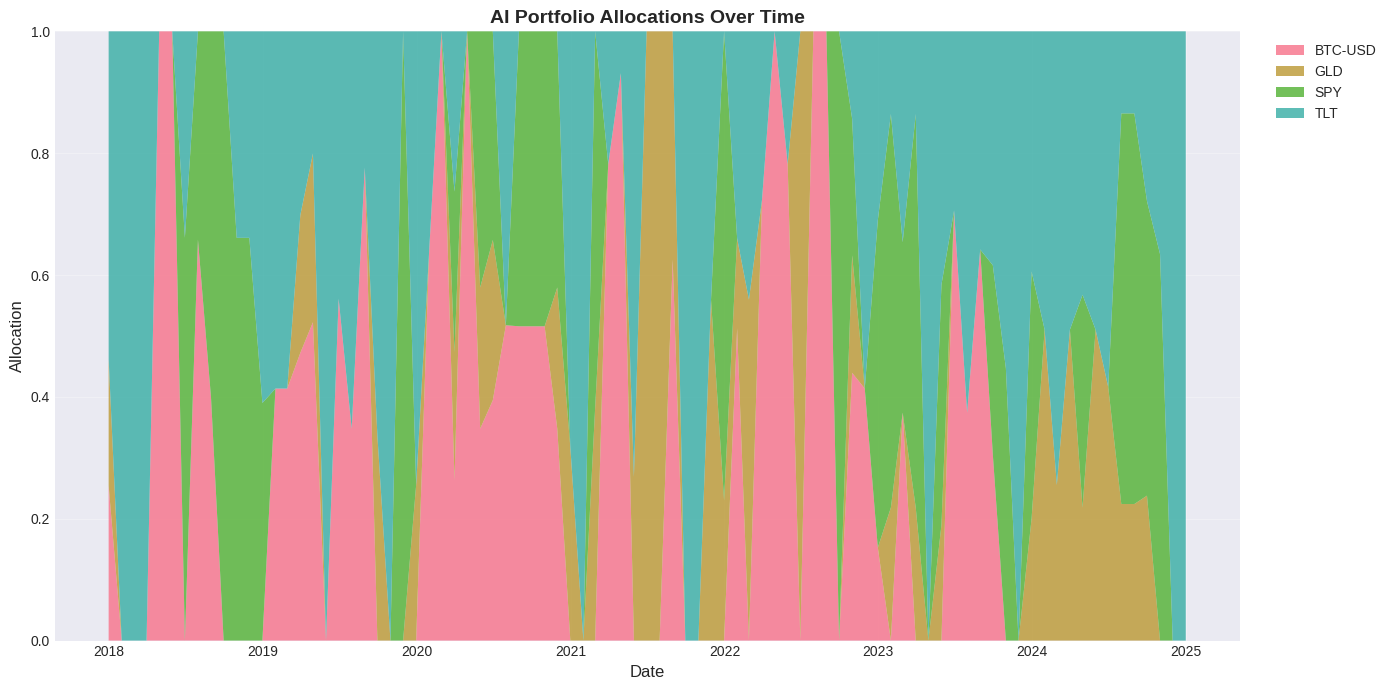

In [11]:
# Visualize allocations over time
allocations_clean = allocations.copy()
allocations_clean.index = pd.to_datetime(allocations_clean.index)
allocations_clean = allocations_clean.apply(pd.to_numeric, errors='coerce')
allocations_clean = allocations_clean.dropna()

fig, ax = plt.subplots(figsize=(14, 7))
ax.stackplot(
    allocations_clean.index,
    *allocations_clean.T.values,
    labels=allocations_clean.columns,
    alpha=0.8
)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Allocation', fontsize=12)
ax.set_title('AI Portfolio Allocations Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1.02, 1))
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Run Backtests

In [12]:
# Backtest AI strategy
print("Backtesting AI Portfolio...")
ai_results = backtester.backtest_strategy(allocations, returns, prices)

# Backtest benchmark (Buy & Hold SPY)
print("Backtesting Buy & Hold SPY...")
benchmark_results = backtester.create_benchmark_strategy(returns, prices, 'SPY')

# Backtest traditional 60/40
print("Backtesting Traditional 60/40...")
traditional_6040_results = backtester.create_traditional_6040(returns, prices)

print("\nAll backtests completed!")

Backtesting AI Portfolio...
Backtesting Buy & Hold SPY...
Backtesting Traditional 60/40...

All backtests completed!


In [13]:
# Display sample results
print("AI Portfolio Results (first 10 periods):")
display(ai_results.head(10))

print("\nAI Portfolio Results (last 10 periods):")
display(ai_results.tail(10))

AI Portfolio Results (first 10 periods):


,Portfolio_Value,Returns,Gross_Returns,Transaction_Costs
2017-12-31,102362.2785,0.0236,0.0236,0
2018-01-31,102871.8189,0.005,0.0059,0.0009
2018-02-28,103525.7099,0.0064,0.0064,0.0
2018-03-31,103525.7099,0.0,0.0,0.0
2018-04-30,101356.4209,-0.021,-0.019,0.002
2018-05-31,102555.8884,0.0118,0.0118,0.0
2018-06-30,102350.7766,-0.002,0.0,0.002
2018-07-31,99093.9395,-0.0318,-0.0305,0.0013
2018-08-31,99381.0305,0.0029,0.0034,0.0005
2018-09-30,99301.6954,-0.0008,0.0,0.0008



AI Portfolio Results (last 10 periods):


,Portfolio_Value,Returns,Gross_Returns,Transaction_Costs
2024-03-31,96822.1209,-0.0005,0.0,0.0005
2024-04-30,95439.7508,-0.0143,-0.0136,0.0007
2024-05-31,95404.7907,-0.0004,0.0003,0.0007
2024-06-30,95386.7913,-0.0002,0.0,0.0002
2024-07-31,96777.2365,0.0146,0.0159,0.0013
2024-08-31,96777.2365,0.0,0.0,0.0
2024-09-30,96621.3112,-0.0016,-0.0013,0.0003
2024-10-31,95431.5317,-0.0123,-0.0118,0.0005
2024-11-30,95310.4845,-0.0013,0.0,0.0013
2024-12-31,96076.4788,0.008,0.008,0.0


## 5. Calculate Performance Metrics

In [14]:
# Calculate metrics for all strategies
strategies = {
    'AI Portfolio': ai_results,
    'Buy & Hold SPY': benchmark_results,
    'Traditional 60/40': traditional_6040_results
}

comparison = backtester.compare_strategies(strategies)

print("="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
display(comparison)

PERFORMANCE COMPARISON


,Sharpe Ratio,Sortino Ratio,Max Drawdown,CAGR,Volatility,Total Return,Final Value,Avg Monthly Return,Monthly Volatility,Best Month,Worst Month,Positive Months,Total Transaction Costs,Calmar Ratio
AI Portfolio,-0.4818,-0.6627,0.1017,-0.0089,0.0506,-0.0614,96076.4788,-0.0004,0.0146,0.0728,-0.0547,0.4353,0.0787,-0.0876
Buy & Hold SPY,-0.9000,-1.2710,0.1142,-0.0064,0.0289,-0.0503,94965.2159,-0.0005,0.0084,0.0315,-0.0196,0.3333,0.0000,-0.0563
Traditional 60/40,-0.8969,-1.3285,0.0715,0.0016,0.0199,0.0131,101584.9759,0.0002,0.0057,0.0218,-0.0144,0.3854,0.0000,0.0227


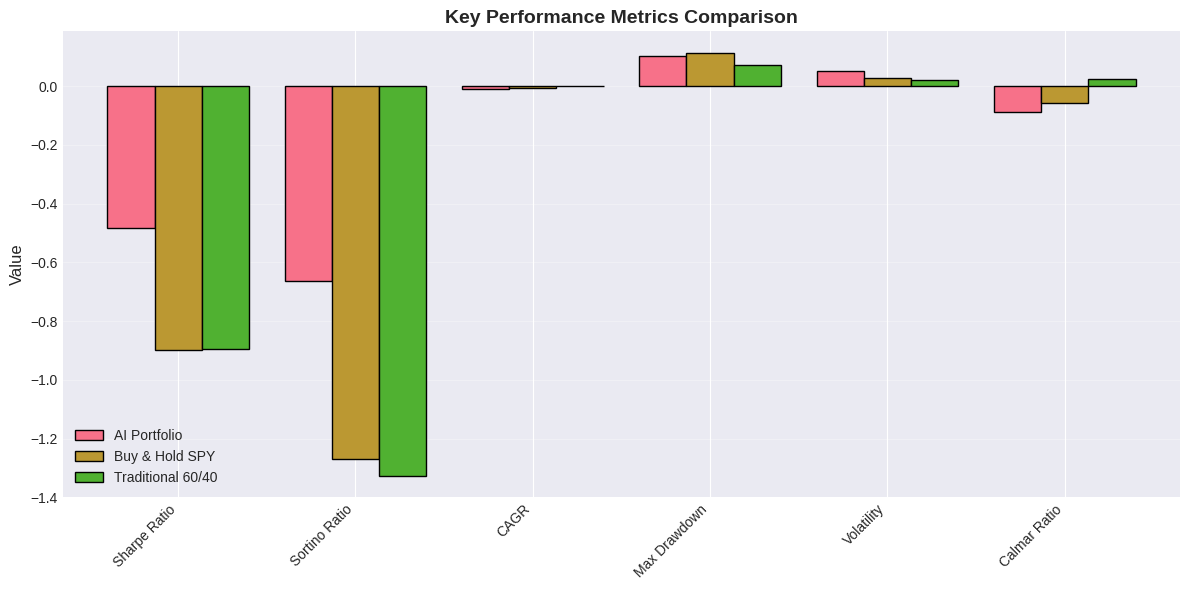

In [16]:
# Highlight key metrics
key_metrics = ['Sharpe Ratio', 'Sortino Ratio', 'CAGR', 'Max Drawdown', 
               'Volatility', 'Calmar Ratio']

key_comparison = comparison[key_metrics]

fig, ax = plt.subplots(figsize=(12, 6))
key_comparison.T.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Key Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
# Calculate improvements over benchmark
print("\n" + "="*70)
print("AI PORTFOLIO IMPROVEMENTS OVER BENCHMARKS")
print("="*70)

for benchmark_name in ['Buy & Hold SPY', 'Traditional 60/40']:
    print(f"\nvs {benchmark_name}:")
    
    for metric in key_metrics:
        ai_value = comparison.loc['AI Portfolio', metric]
        bench_value = comparison.loc[benchmark_name, metric]
        
        if metric == 'Max Drawdown':
            # Lower is better for drawdown
            improvement = ((bench_value - ai_value) / bench_value) * 100
        else:
            # Higher is better for other metrics
            improvement = ((ai_value - bench_value) / bench_value) * 100
        
        print(f"  {metric}: {improvement:+.2f}%")


AI PORTFOLIO IMPROVEMENTS OVER BENCHMARKS

vs Buy & Hold SPY:
  Sharpe Ratio: -46.47%
  Sortino Ratio: -47.86%
  CAGR: +38.61%
  Max Drawdown: +10.91%
  Volatility: +74.97%
  Calmar Ratio: +55.58%

vs Traditional 60/40:
  Sharpe Ratio: -46.29%
  Sortino Ratio: -50.12%
  CAGR: -647.75%
  Max Drawdown: -42.23%
  Volatility: +154.54%
  Calmar Ratio: -485.11%


## 6. Portfolio Value Analysis

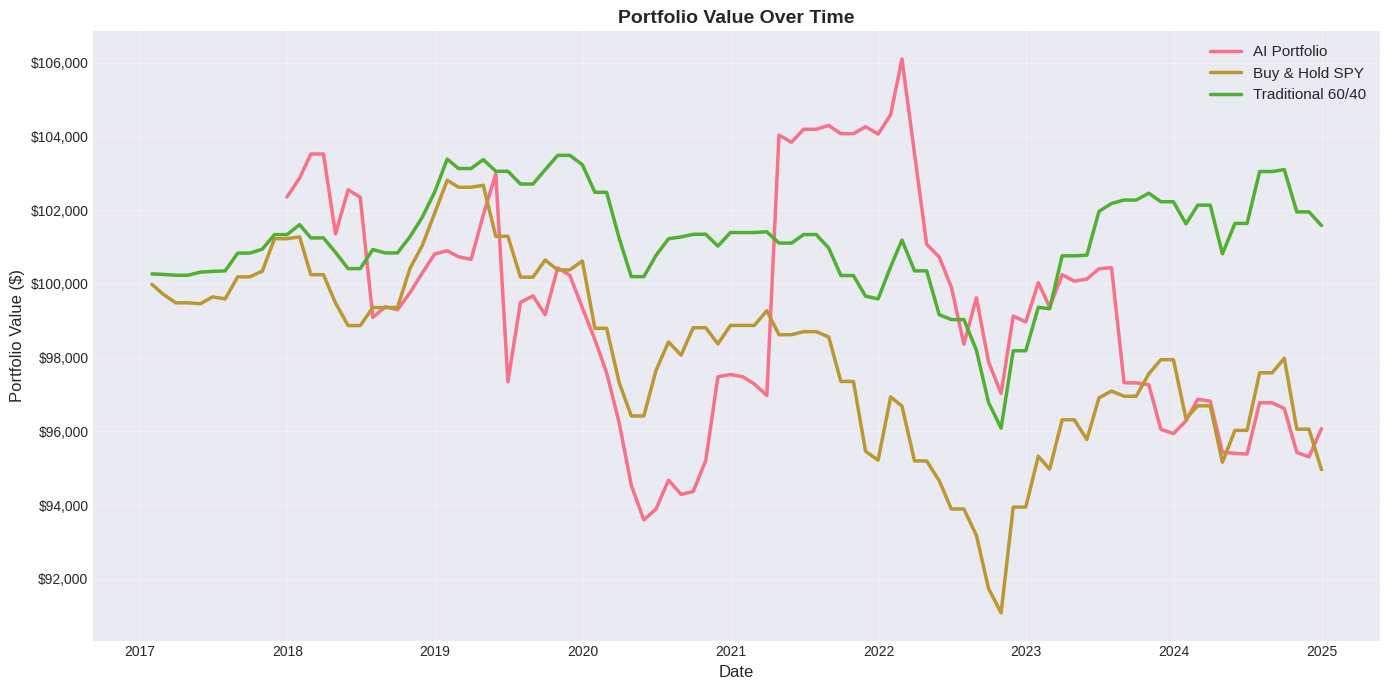


Final Portfolio Values:
  AI Portfolio: $96,076.48 (-3.92%)
  Buy & Hold SPY: $94,965.22 (-5.03%)
  Traditional 60/40: $101,584.98 (+1.58%)


In [18]:
# Plot portfolio values
fig, ax = plt.subplots(figsize=(14, 7))

for name, results in strategies.items():
    ax.plot(results.index, results['Portfolio_Value'], label=name, linewidth=2.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.tight_layout()
plt.show()

# Print final values
print("\nFinal Portfolio Values:")
for name, results in strategies.items():
    final_value = results['Portfolio_Value'].iloc[-1]
    total_return = (final_value / config['backtest']['initial_capital'] - 1) * 100
    print(f"  {name}: ${final_value:,.2f} ({total_return:+.2f}%)")

In [19]:
# Backtest AI strategy
print("Backtesting AI Portfolio...")
ai_results = backtester.backtest_strategy(allocations, returns, prices)

# Backtest benchmark (Buy & Hold SPY)
print("Backtesting Buy & Hold SPY...")
benchmark_results = backtester.create_benchmark_strategy(returns, prices, 'SPY')

# Backtest traditional 60/40
print("Backtesting Traditional 60/40...")
traditional_6040_results = backtester.create_traditional_6040(returns, prices)

print("\nAll backtests completed!")


Backtesting AI Portfolio...
Backtesting Buy & Hold SPY...
Backtesting Traditional 60/40...

All backtests completed!


## 7. Drawdown Analysis

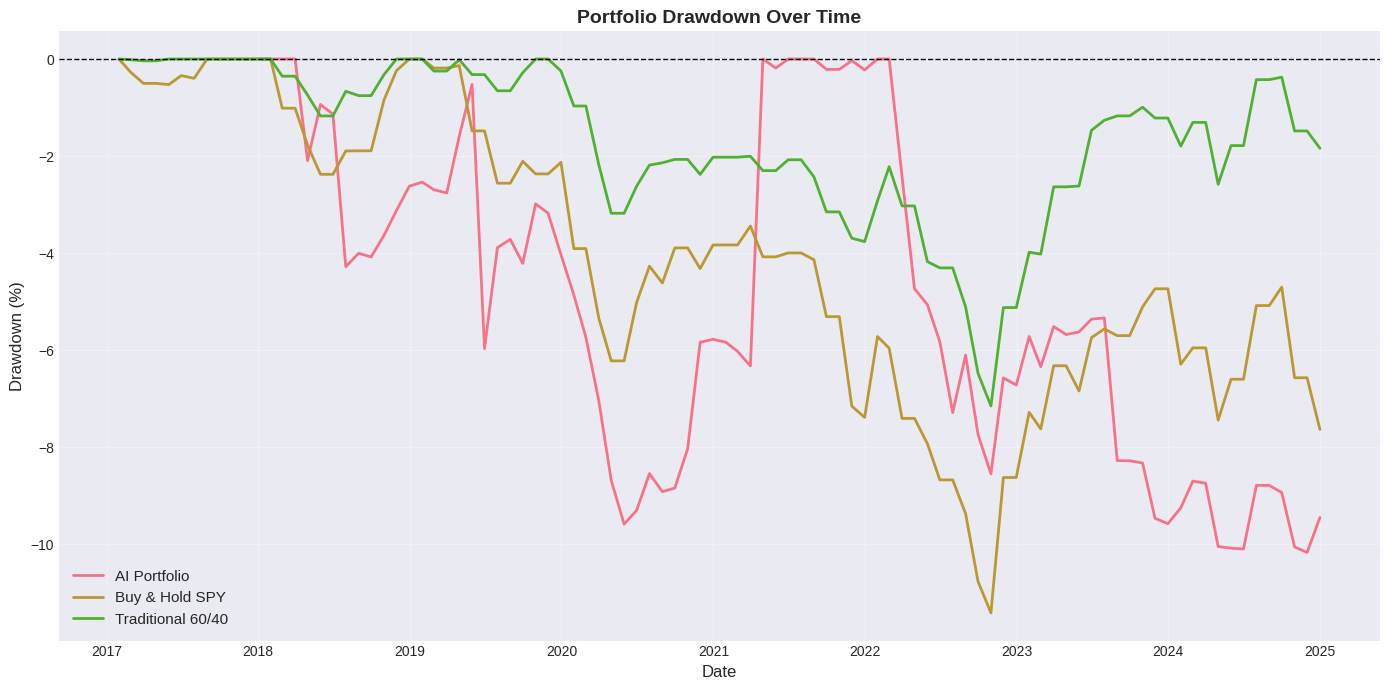


Maximum Drawdowns:
  AI Portfolio: 10.17%
  Buy & Hold SPY: 11.42%
  Traditional 60/40: 7.15%


In [20]:
# Plot drawdowns
fig, ax = plt.subplots(figsize=(14, 7))

for name, results in strategies.items():
    portfolio_value = results['Portfolio_Value']
    cummax = portfolio_value.cummax()
    drawdown = (portfolio_value - cummax) / cummax
    
    ax.plot(drawdown.index, drawdown * 100, label=name, linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_title('Portfolio Drawdown Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print("\nMaximum Drawdowns:")
for name in strategies.keys():
    max_dd = comparison.loc[name, 'Max Drawdown']
    print(f"  {name}: {max_dd:.2%}")

## 8. Returns Analysis

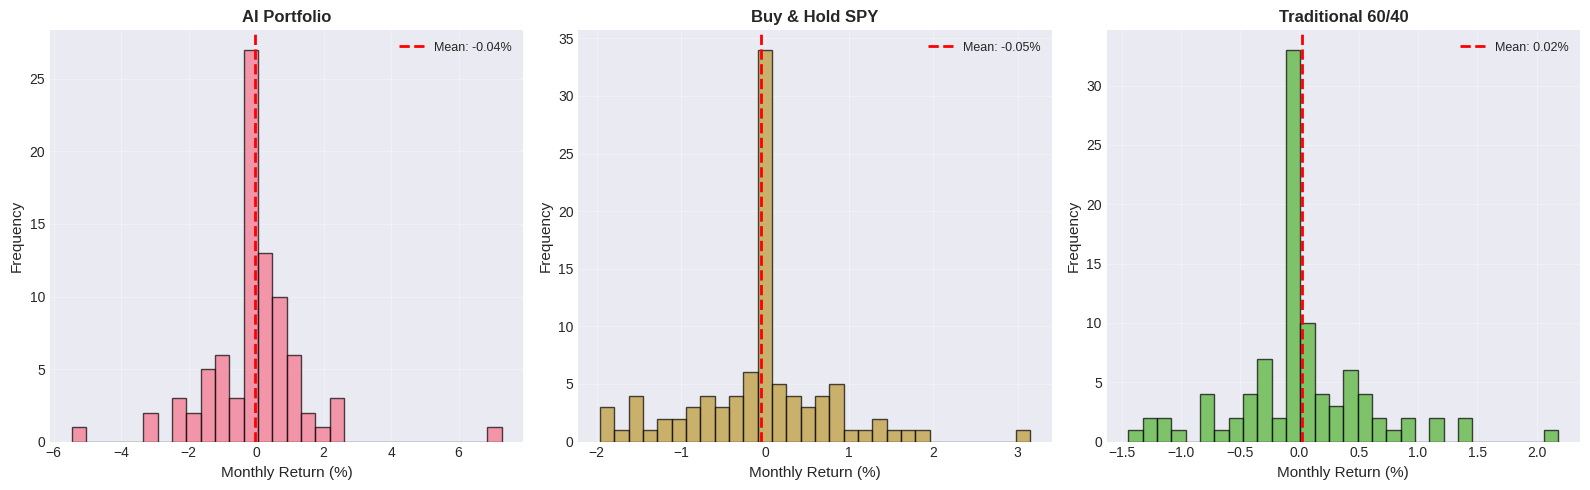

In [21]:
# Plot returns distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, results) in enumerate(strategies.items()):
    returns_series = results['Returns']
    
    axes[idx].hist(returns_series * 100, bins=30, edgecolor='black', alpha=0.7, color=f'C{idx}')
    axes[idx].axvline(returns_series.mean() * 100, color='red', linestyle='--', 
                     linewidth=2, label=f'Mean: {returns_series.mean()*100:.2f}%')
    axes[idx].set_xlabel('Monthly Return (%)', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

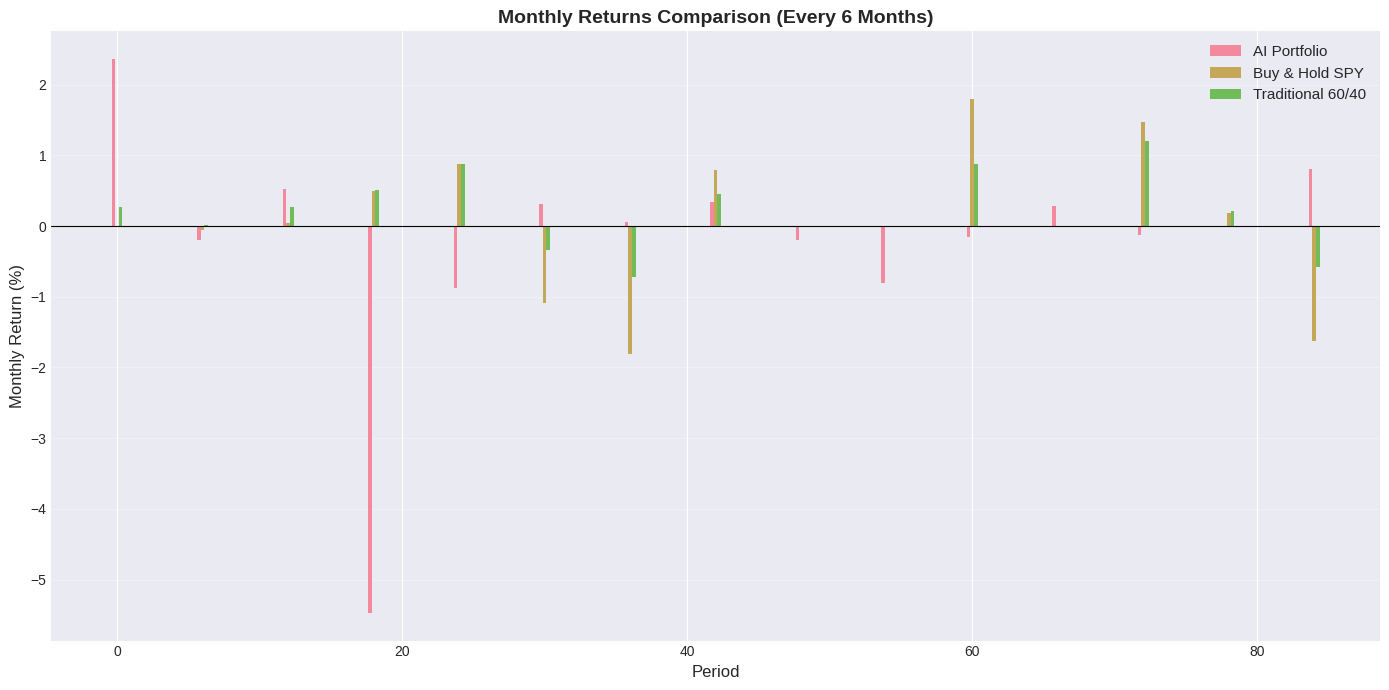

In [27]:
# Monthly returns comparison
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(ai_results))
width = 0.25

for idx, (name, results) in enumerate(strategies.items()):
    offset = (idx - 1) * width
    returns_pct = results['Returns'] * 100

    plot_indices = x[::6]
    plot_returns = returns_pct.values[::6]
    min_len = min(len(plot_indices), len(plot_returns))
    plot_indices = plot_indices[:min_len]
    plot_returns = plot_returns[:min_len]

    ax.bar(plot_indices + offset, plot_returns, width, label=name, alpha=0.8)

ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Monthly Return (%)', fontsize=12)
ax.set_title('Monthly Returns Comparison (Every 6 Months)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

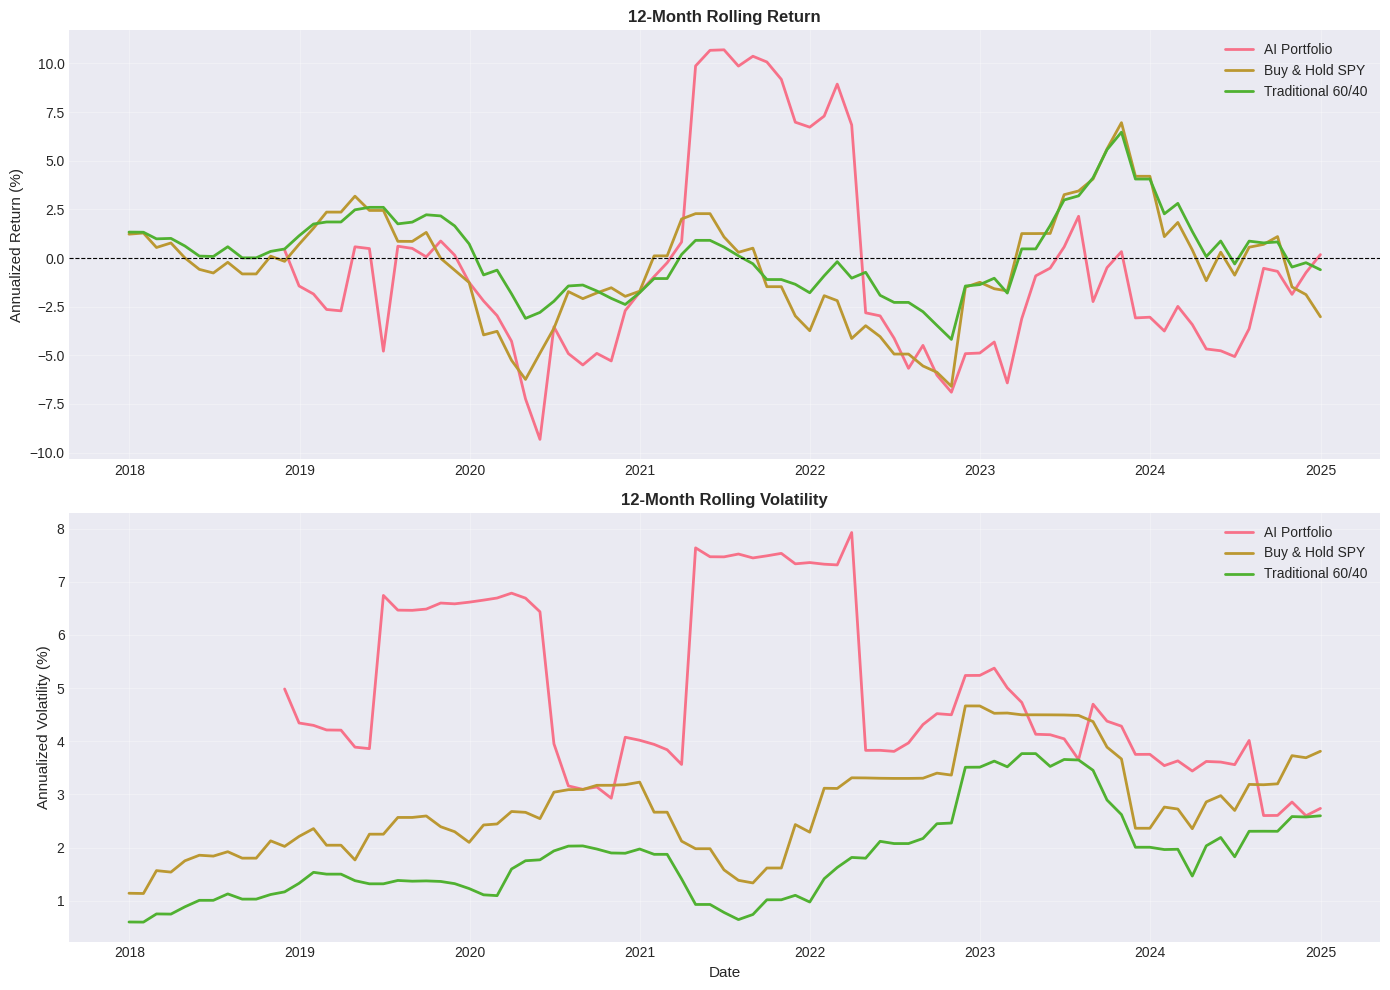

In [28]:
# Rolling metrics
window = 12  # 12-month rolling window

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling returns
for name, results in strategies.items():
    rolling_returns = results['Returns'].rolling(window).mean() * 12 * 100
    axes[0].plot(rolling_returns.index, rolling_returns, label=name, linewidth=2)

axes[0].set_ylabel('Annualized Return (%)', fontsize=11)
axes[0].set_title(f'{window}-Month Rolling Return', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Rolling volatility
for name, results in strategies.items():
    rolling_vol = results['Returns'].rolling(window).std() * np.sqrt(12) * 100
    axes[1].plot(rolling_vol.index, rolling_vol, label=name, linewidth=2)

axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Annualized Volatility (%)', fontsize=11)
axes[1].set_title(f'{window}-Month Rolling Volatility', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Risk-Adjusted Returns

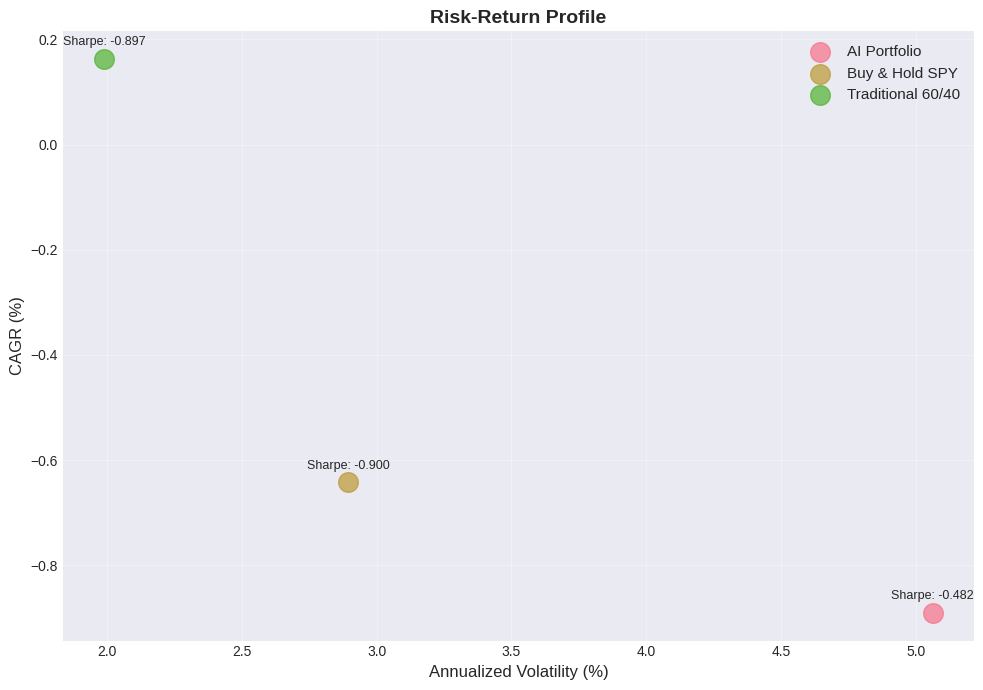

In [23]:
# Risk-return scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

for name in strategies.keys():
    ret = comparison.loc[name, 'CAGR'] * 100
    vol = comparison.loc[name, 'Volatility'] * 100
    sharpe = comparison.loc[name, 'Sharpe Ratio']
    
    ax.scatter(vol, ret, s=200, label=name, alpha=0.7)
    ax.annotate(f'Sharpe: {sharpe:.3f}', 
               (vol, ret), 
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               fontsize=9)

ax.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax.set_ylabel('CAGR (%)', fontsize=12)
ax.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Transaction Cost Analysis

Transaction Cost Analysis (AI Portfolio):
  Total transaction costs: $0.08
  Average monthly cost: $0.00
  As % of initial capital: 0.00%


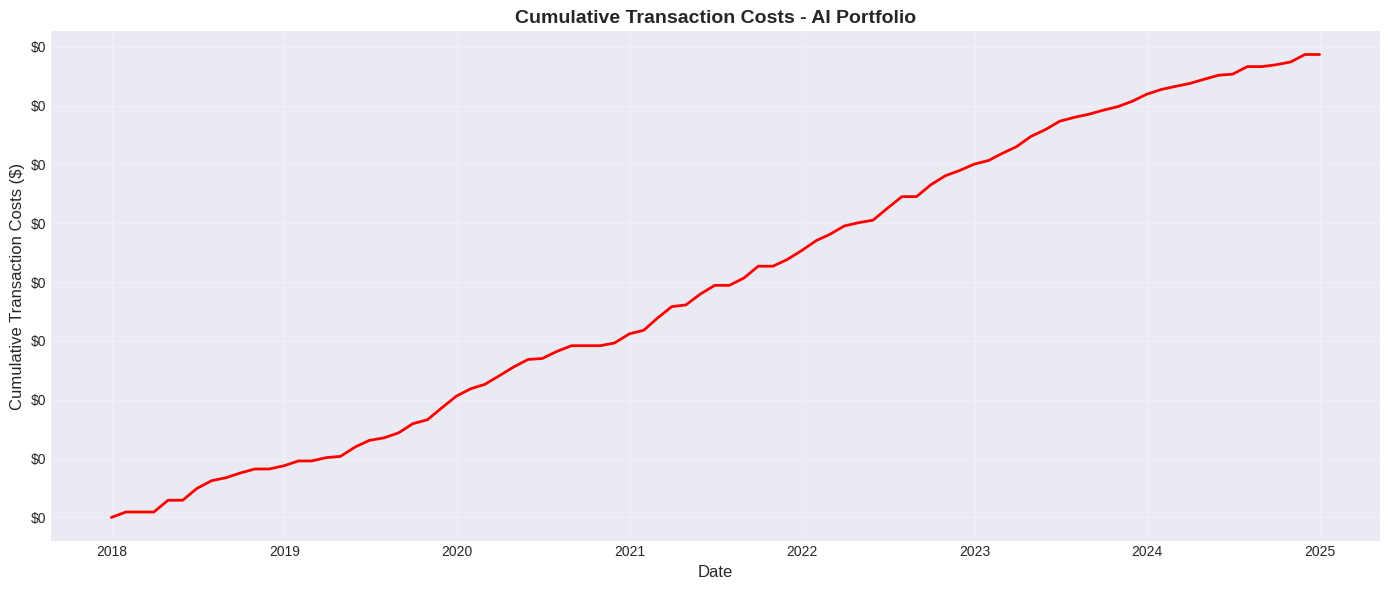

In [24]:
# Analyze transaction costs for AI portfolio
total_costs = ai_results['Transaction_Costs'].sum()
avg_monthly_cost = ai_results['Transaction_Costs'].mean()

print(f"Transaction Cost Analysis (AI Portfolio):")
print(f"  Total transaction costs: ${total_costs:,.2f}")
print(f"  Average monthly cost: ${avg_monthly_cost:,.2f}")
print(f"  As % of initial capital: {(total_costs/config['backtest']['initial_capital'])*100:.2f}%")

# Plot cumulative transaction costs
fig, ax = plt.subplots(figsize=(14, 6))
cumulative_costs = ai_results['Transaction_Costs'].cumsum()
ax.plot(cumulative_costs.index, cumulative_costs, linewidth=2, color='red')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Transaction Costs ($)', fontsize=12)
ax.set_title('Cumulative Transaction Costs - AI Portfolio', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.tight_layout()
plt.show()

## 11. Summary and Key Findings

### Performance Summary:

In [25]:
# Create summary table
summary = pd.DataFrame({
    'Metric': [
        'Sharpe Ratio',
        'Sortino Ratio', 
        'CAGR',
        'Max Drawdown',
        'Volatility',
        'Calmar Ratio',
        'Final Value',
        'Total Return'
    ]
})

for name in strategies.keys():
    summary[name] = [
        f"{comparison.loc[name, 'Sharpe Ratio']:.4f}",
        f"{comparison.loc[name, 'Sortino Ratio']:.4f}",
        f"{comparison.loc[name, 'CAGR']*100:.2f}%",
        f"{comparison.loc[name, 'Max Drawdown']*100:.2f}%",
        f"{comparison.loc[name, 'Volatility']*100:.2f}%",
        f"{comparison.loc[name, 'Calmar Ratio']:.4f}",
        f"${comparison.loc[name, 'Final Value']:,.2f}",
        f"{comparison.loc[name, 'Total Return']*100:.2f}%"
    ]

print("="*80)
print("FINAL PERFORMANCE SUMMARY")
print("="*80)
display(summary)

FINAL PERFORMANCE SUMMARY


,Metric,AI Portfolio,Buy & Hold SPY,Traditional 60/40
0,Sharpe Ratio,-0.4818,-0.9000,-0.8969
1,Sortino Ratio,-0.6627,-1.2710,-1.3285
2,CAGR,-0.89%,-0.64%,0.16%
3,Max Drawdown,10.17%,11.42%,7.15%
4,Volatility,5.06%,2.89%,1.99%
5,Calmar Ratio,-0.0876,-0.0563,0.0227
6,Final Value,"$96,076.48","$94,965.22","$101,584.98"
7,Total Return,-6.14%,-5.03%,1.31%
